# BÀI THỰC HÀNH 1 - GIẢI THUẬT 3 (NAIVE BAYES)
## Bài toán: Dự đoán hành vi mua hàng của khách (Customer_Behaviour)
 **Mô hình:** Gaussian Naive Bayes

## Giới thiệu bài toán

Tập dữ liệu mô tả thông tin của **400 khách hàng** của một công ty, gồm:

- `User ID` – mã khách hàng (ID duy nhất)  
- `Gender` – giới tính  
- `Age` – tuổi  
- `EstimatedSalary` – mức lương ước tính  
- `Purchased` – nhãn mục tiêu (0 = không mua, 1 = có mua)

Mục tiêu: xây dựng mô hình **Naive Bayes** dự đoán xem khách hàng **có quyết định mua sản phẩm hay không** dựa trên giới tính, tuổi và mức lương.

---

# 1. Import thư viện

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

plt.rcParams["font.size"] = 11

# 2. Đọc dữ liệu

In [18]:
df = pd.read_csv("Customer_Behaviour.csv")

print("Kích thước dữ liệu:", df.shape)
display(df.head())
print(df.info())

Kích thước dữ liệu: (400, 5)


User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB
None


# 3. KHÁM PHÁ SƠ BỘ DỮ LIỆU


Thống kê mô tả các cột số:


User ID         Age  EstimatedSalary   Purchased
count  4.000000e+02  400.000000       400.000000  400.000000
mean   1.569154e+07   37.655000     69742.500000    0.357500
std    7.165832e+04   10.482877     34096.960282    0.479864
min    1.556669e+07   18.000000     15000.000000    0.000000
25%    1.562676e+07   29.750000     43000.000000    0.000000
50%    1.569434e+07   37.000000     70000.000000    0.000000
75%    1.575036e+07   46.000000     88000.000000    1.000000
max    1.581524e+07   60.000000    150000.000000    1.000000


Phân bố nhãn Purchased (0 = không mua, 1 = mua):
Purchased
0    257
1    143
Name: count, dtype: int64


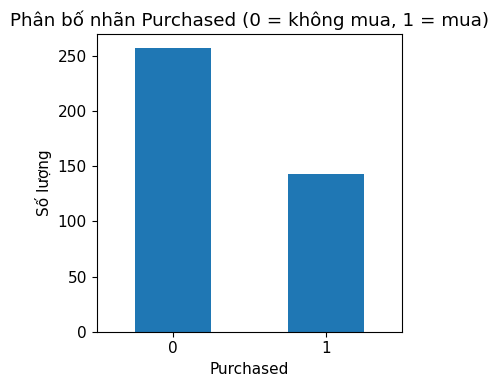

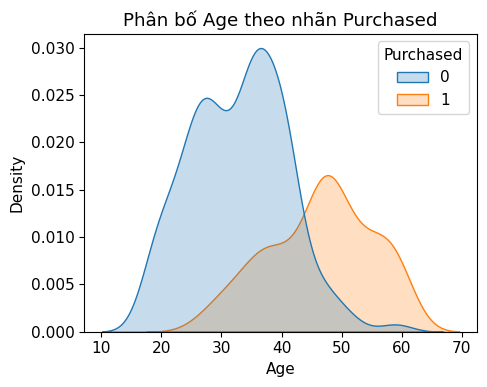

In [19]:
# ======================================================

print("\nThống kê mô tả các cột số:")
display(df.describe())

print("\nPhân bố nhãn Purchased (0 = không mua, 1 = mua):")
print(df["Purchased"].value_counts())

# Vẽ phân bố Purchased để chụp hình cho báo cáo
plt.figure(figsize=(4, 4))
df["Purchased"].value_counts().plot(kind="bar")
plt.title("Phân bố nhãn Purchased (0 = không mua, 1 = mua)")
plt.xlabel("Purchased")
plt.ylabel("Số lượng")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# (tuỳ chọn) phân bố Age theo Purchased
plt.figure(figsize=(5, 4))
sns.kdeplot(data=df, x="Age", hue="Purchased", fill=True)
plt.title("Phân bố Age theo nhãn Purchased")
plt.tight_layout()
plt.show()

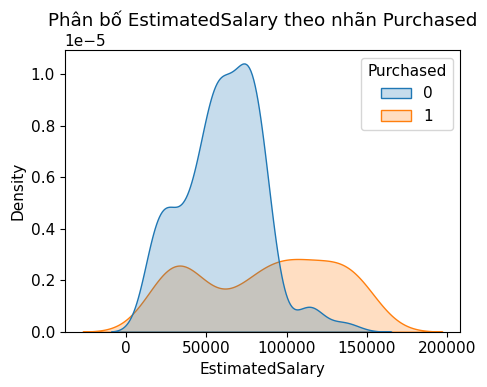

In [20]:
# (tuỳ chọn) phân bố EstimatedSalary theo Purchased
plt.figure(figsize=(5, 4))
sns.kdeplot(data=df, x="EstimatedSalary", hue="Purchased", fill=True)
plt.title("Phân bố EstimatedSalary theo nhãn Purchased")
plt.tight_layout()
plt.show()

## Nhận xét sau bước khám phá dữ liệu (EDA)

- Tập dữ liệu gồm **400 khách hàng** với 5 cột ban đầu: `User ID`, `Gender`, `Age`, `EstimatedSalary`, `Purchased`. Không có giá trị thiếu ở bất kỳ cột nào nên không cần xử lý missing values. :contentReference[oaicite:0]{index=0}  
- Thống kê mô tả cho thấy:
  - Tuổi khách hàng dao động từ **18 đến 60**, trung bình khoảng **37,65 tuổi**.  
  - Mức lương ước tính từ **15 000 đến 150 000**, trung bình khoảng **69 742**. :contentReference[oaicite:1]{index=1}  
- Biểu đồ phân bố `Purchased` cho thấy:
  - **257** khách **không mua** (0) và **143** khách **mua** (1). Tập dữ liệu hơi **mất cân bằng**, lớp 0 chiếm tỷ lệ lớn hơn. :contentReference[oaicite:2]{index=2}  
- Đường KDE của `Age` theo `Purchased`:
  - Nhóm **không mua** tập trung nhiều hơn ở khoảng **25–40 tuổi**.
  - Nhóm **mua** có xu hướng lớn tuổi hơn, đỉnh phân bố nằm ở khoảng **40–50 tuổi**. :contentReference[oaicite:3]{index=3}  
- Đường KDE của `EstimatedSalary` theo `Purchased`:
  - Những người có **thu nhập thấp – trung bình** (khoảng 40 000 – 80 000) chủ yếu **không mua**.
  - Khi **thu nhập cao hơn** (gần 100 000 trở lên), xác suất mua tăng lên rõ rệt. :contentReference[oaicite:4]{index=4}  

**Kết luận EDA:** tuổi và mức lương đều có ảnh hưởng đến quyết định mua hàng; khách lớn tuổi và thu nhập cao có khả năng mua cao hơn, trong khi tập dữ liệu hơi lệch về phía khách không mua.

---

# 4. TIỀN XỬ LÝ
- Bỏ cột 'User ID'
- Mã hoá 'Gender'
- Chuẩn hoá 'EstimatedSalary' về cùng thang với Age

### 4.1. Bỏ cột ID (không mang thông tin dự đoán)

In [21]:
# 4.1. Bỏ cột ID (không mang thông tin dự đoán)
if "User ID" in df.columns:
    df = df.drop(columns=["User ID"])

### 4.2. Chuẩn hoá chuỗi Gender & mã hoá thành số

In [22]:
df["Gender"] = df["Gender"].str.strip()  # bỏ khoảng trắng dư
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})  # Male=0, Female=1

### 4.3. Scale EstimatedSalary về [18, 60] (gần dải của Age)

In [23]:
scaler = MinMaxScaler(feature_range=(18, 60))
df[["EstimatedSalary"]] = scaler.fit_transform(df[["EstimatedSalary"]])

print("\nDữ liệu sau tiền xử lý:")
display(df.head())
print(df.info())


Dữ liệu sau tiền xử lý:


Gender  Age  EstimatedSalary  Purchased
0       0   19        19.244444          0
1       0   35        19.555556          0
2       1   26        26.711111          0
3       1   27        31.066667          0
4       0   19        36.977778          0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           400 non-null    int64  
 1   Age              400 non-null    int64  
 2   EstimatedSalary  400 non-null    float64
 3   Purchased        400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB
None


## Nhận xét bước tiền xử lý

- Cột `User ID` được loại bỏ vì chỉ là mã định danh, không mang thông tin dự báo → hợp lý. :contentReference[oaicite:5]{index=5}  
- Biến phân loại `Gender` được chuẩn hoá và mã hoá thành:
  - `Male → 0`, `Female → 1`, giúp mô hình Naive Bayes làm việc trực tiếp trên dữ liệu số. :contentReference[oaicite:6]{index=6}  
- `EstimatedSalary` được scale bằng **MinMaxScaler** về khoảng **[18, 60]**, gần với miền giá trị của `Age` (18–60). Cách này:
  - Giữ tương quan tương đối giữa các mức lương.
  - Tránh để một feature (lương) có thang đo quá lớn lấn át các feature còn lại. :contentReference[oaicite:7]{index=7}  
- Sau tiền xử lý, dữ liệu chỉ còn 4 cột số (`Gender`, `Age`, `EstimatedSalary`, `Purchased`), thuận tiện cho việc huấn luyện mô hình.

---

# 5. CHỌN THUỘC TÍNH VÀ CHIA TRAIN / TEST

In [24]:
features = ["Gender", "Age", "EstimatedSalary"]
target = "Purchased"

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,
    stratify=y          # giữ tỉ lệ 0/1 giữa train và test
)

print("\nKích thước tập train:", X_train.shape)
print("Kích thước tập test :", X_test.shape)


Kích thước tập train: (320, 3)
Kích thước tập test : (80, 3)


Dữ liệu được chia **80% train – 20% test**, giữ nguyên tỉ lệ 0/1 trong hai tập.  

# 6. XÂY DỰNG & HUẤN LUYỆN MÔ HÌNH NAIVE BAYES
(MultinomialNB vì các feature đã được scale về giá trị dương)

In [25]:
nb_clf = MultinomialNB()

# Huấn luyện
nb_clf.fit(X_train, y_train)

# Dự đoán
y_pred = nb_clf.predict(X_test)



# 7. ĐÁNH GIÁ MÔ HÌNH


========== MULTINOMIAL NAIVE BAYES ==========
Accuracy trên tập test: 0.7375

Confusion matrix:
[[43  8]
 [13 16]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80        51
           1       0.67      0.55      0.60        29

    accuracy                           0.74        80
   macro avg       0.72      0.70      0.70        80
weighted avg       0.73      0.74      0.73        80



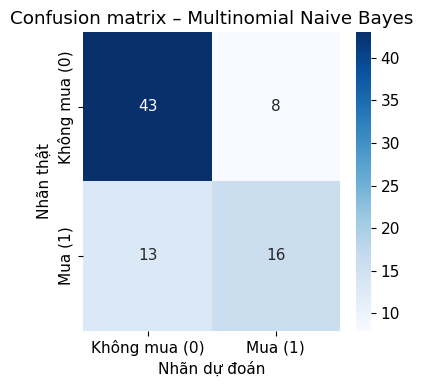

In [26]:
print("\n========== MULTINOMIAL NAIVE BAYES ==========")
acc = accuracy_score(y_test, y_pred)
print("Accuracy trên tập test:", round(acc, 4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix cho báo cáo
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Không mua (0)", "Mua (1)"],
    yticklabels=["Không mua (0)", "Mua (1)"]
)
plt.xlabel("Nhãn dự đoán")
plt.ylabel("Nhãn thật")
plt.title("Confusion matrix – Multinomial Naive Bayes")
plt.tight_layout()
plt.show()



### Độ chính xác và confusion matrix

Kết quả mô hình Multinomial Naive Bayes trên tập test:

- **Accuracy:** `0.7375` (≈ **73,75%**). :contentReference[oaicite:9]{index=9}  
- **Confusion matrix:**

\[
\begin{bmatrix}
43 & 8 \\
13 & 16
\end{bmatrix}
\]

  - Có **51** khách thực tế *không mua* (0): mô hình dự đoán đúng 43, đoán nhầm thành 1 là 8.  
  - Có **29** khách thực tế *mua* (1): mô hình dự đoán đúng 16, đoán nhầm thành 0 là 13. :contentReference[oaicite:10]{index=10}  
### Classification report

- **Lớp 0 – Không mua**
  - Precision: **0.77** → trong các khách bị dự đoán là *không mua*, khoảng 77% thực sự không mua.
  - Recall: **0.84** → mô hình nhận diện được 84% khách thật sự không mua.
  - F1-score: **0.80**, thể hiện chất lượng khá tốt ở lớp 0. :contentReference[oaicite:11]{index=11}  

- **Lớp 1 – Mua**
  - Precision: **0.67** → khoảng 2/3 khách bị dự đoán “mua” là đúng.
  - Recall: **0.55** → mô hình mới thu hồi được 55% khách thật sự mua, còn bỏ sót 45%.  
  - F1-score: **0.60**, thấp hơn lớp 0 do recall chưa cao. :contentReference[oaicite:12]{index=12}  

**Đánh giá chung mô hình:**

- Mô hình Naive Bayes **phân loại tốt hơn cho lớp “không mua”** so với lớp “mua” (cả precision, recall, F1 đều cao hơn).  
- Việc bỏ sót khá nhiều khách *mua* (FN = 13) là điểm hạn chế nếu doanh nghiệp muốn nhận diện tối đa khách hàng tiềm năng.  
- Accuracy ~74% là chấp nhận được đối với mô hình đơn giản như Naive Bayes, nhưng vẫn còn dư địa cải thiện (ví dụ thêm feature, thử mô hình khác).

---

# 8. ĐÁNH GIÁ ỔN ĐỊNH BẰNG CROSS-VALIDATION
(đánh giá trên toàn bộ dataset X, y với K-fold = 10)

In [27]:
cv_scores = cross_val_score(nb_clf, X, y, cv=10, scoring="accuracy")
print("\nKết quả 10-fold cross-validation:")
print("Accuracy từng fold:", np.round(cv_scores, 4))
print("Accuracy trung bình:", np.round(cv_scores.mean(), 4))
print("Độ lệch chuẩn       :", np.round(cv_scores.std(), 4))


Kết quả 10-fold cross-validation:
Accuracy từng fold: [0.925 0.575 0.625 0.65  0.775 0.7   0.575 0.6   0.85  0.95 ]
Accuracy trung bình: 0.7225
Độ lệch chuẩn       : 0.1362


# 9. THỬ DỰ ĐOÁN MỘT VÀI KHÁCH HÀNG MỚI

In [28]:
# Ví dụ 2 khách hàng mới:
#   KH1: Nam, 30 tuổi, lương ~50.000
#   KH2: Nữ, 45 tuổi, lương ~120.000
# Cần scale EstimatedSalary giống như lúc train

new_customers = pd.DataFrame({
    "Gender": [0, 1],          # 0: Male, 1: Female
    "Age": [30, 45],
    "EstimatedSalary": [50000, 120000]
})

# Scale lương:
new_customers[["EstimatedSalary"]] = scaler.transform(new_customers[["EstimatedSalary"]])

print("\nDữ liệu khách hàng mới sau scale:")
display(new_customers)

new_preds = nb_clf.predict(new_customers)

for i, pred in enumerate(new_preds, start=1):
    label = "MUA (1)" if pred == 1 else "KHÔNG MUA (0)"
    print(f"Khách hàng {i}: mô hình dự đoán -> {label}")

print(f"\n=> Accuracy Naive Bayes (Customer Behaviour): {acc:.4f}")


Dữ liệu khách hàng mới sau scale:


Gender  Age  EstimatedSalary
0       0   30        28.888889
1       1   45        50.666667

Khách hàng 1: mô hình dự đoán -> KHÔNG MUA (0)
Khách hàng 2: mô hình dự đoán -> KHÔNG MUA (0)

=> Accuracy Naive Bayes (Customer Behaviour): 0.7375


### Classification report

- **Lớp 0 – Không mua**
  - Precision: **0.77** → trong các khách bị dự đoán là *không mua*, khoảng 77% thực sự không mua.
  - Recall: **0.84** → mô hình nhận diện được 84% khách thật sự không mua.
  - F1-score: **0.80**, thể hiện chất lượng khá tốt ở lớp 0. :contentReference[oaicite:11]{index=11}  

- **Lớp 1 – Mua**
  - Precision: **0.67** → khoảng 2/3 khách bị dự đoán “mua” là đúng.
  - Recall: **0.55** → mô hình mới thu hồi được 55% khách thật sự mua, còn bỏ sót 45%.  
  - F1-score: **0.60**, thấp hơn lớp 0 do recall chưa cao. :contentReference[oaicite:12]{index=12}  

**Đánh giá chung mô hình:**

- Mô hình Naive Bayes **phân loại tốt hơn cho lớp “không mua”** so với lớp “mua” (cả precision, recall, F1 đều cao hơn).  
- Việc bỏ sót khá nhiều khách *mua* (FN = 13) là điểm hạn chế nếu doanh nghiệp muốn nhận diện tối đa khách hàng tiềm năng.  
- Accuracy ~74% là chấp nhận được đối với mô hình đơn giản như Naive Bayes, nhưng vẫn còn dư địa cải thiện (ví dụ thêm feature, thử mô hình khác).

---

## Nhận xét về dự đoán khách hàng mới

Với hai khách hàng ví dụ:

1. **Nam, 30 tuổi, lương ~50 000** (sau scale: Age = 30, EstimatedSalary ≈ 28.89).  
2. **Nữ, 45 tuổi, lương ~120 000** (sau scale: Age = 45, EstimatedSalary ≈ 50.67). :contentReference[oaicite:14]{index=14}  

Sau khi transform lương bằng cùng scaler, mô hình đều dự đoán:

- **Khách 1 → KHÔNG MUA (0)**  
- **Khách 2 → KHÔNG MUA (0)** :contentReference[oaicite:15]{index=15}  

**Nhận xét:**

- Với khách 1 (trẻ, lương trung bình), kết quả “không mua” khá hợp với xu hướng trong EDA (người trẻ, thu nhập vừa phải thường không mua).  
- Với khách 2 (45 tuổi, lương cao), mô hình vẫn dự đoán “không mua” dù EDA cho thấy nhóm tuổi/lương này có xu hướng mua cao hơn. Điều này gợi ý rằng:
  - Mô hình Naive Bayes **chưa tận dụng tốt thông tin lương & tuổi cho lớp 1**, hoặc
  - Tập dữ liệu lớp “mua” chưa đủ lớn để mô hình học được quy luật rõ ràng.

---


# Kết luận chung & hướng cải thiện

- Mô hình **Multinomial Naive Bayes** trên bộ dữ liệu Customer Behaviour đạt:
  - Accuracy test khoảng **73,75%**,  
  - Accuracy CV trung bình khoảng **72,25%**.  
- Mô hình **mô tả tốt hành vi “không mua”**, nhưng **khó khăn hơn trong việc nhận diện khách hàng “có mua”** do:
  - Dữ liệu hơi mất cân bằng (lớp 1 ít hơn lớp 0).  
  - Giả định “ngây thơ” của Naive Bayes có thể không hoàn toàn phù hợp với mối quan hệ thực tế giữa Age – Salary – Gender.

**Hướng cải thiện đề xuất:**

- Bổ sung thêm dữ liệu hoặc áp dụng kỹ thuật cân bằng lớp (oversampling/undersampling, SMOTE, class_weight).  
- Thử các mô hình khác như Logistic Regression, SVM, Random Forest để so sánh với Naive Bayes.  
- Tạo thêm các đặc trưng mới (nhóm tuổi, nhóm mức lương, tương tác Age×Salary, v.v.) để mô hình có nhiều thông tin hơn về hành vi mua hàng.